In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Define la estructura del modelo

# Model definition
dropout_rate = 0.5
number_raster_layers = 9
number_pixels_layer = 19

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(number_raster_layers, 16, kernel_size=3, stride=1, padding=1)
        self.selu1 = nn.SELU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.selu2 = nn.SELU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.selu3 = nn.SELU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.selu4 = nn.SELU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.selu5 = nn.SELU()
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.selu6 = nn.SELU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * number_pixels_layer * number_pixels_layer, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.selu1(x)
        x = self.conv2(x)
        x = self.selu2(x)
        x = self.conv3(x)
        x = self.selu3(x)
        x = self.conv4(x)
        x = self.selu4(x)
        x = self.conv5(x)
        x = self.selu5(x)
        x = self.conv6(x)
        x = self.selu6(x)
        x = self.flatten(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

model = CNNRegressor()

In [3]:
# Load model
path_model = '../Data/Calibrated_models/global_regressor_V0.pth'
model.load_state_dict(torch.load(path_model))


<All keys matched successfully>

In [4]:
# Cambia el modelo al modo de evaluación (si es necesario)
model.eval()

CNNRegressor(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu1): SELU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu2): SELU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu3): SELU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu4): SELU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu5): SELU()
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu6): SELU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=184832, out_features=1, bias=True)
)

In [5]:
# Load tensors
path_tensor_train = '../Data/Calibrated_models/global_regressor_V0_tensor_y_train.pth'
y_train = torch.load(path_tensor_train)

path_tensor_test = '../Data/Calibrated_models/global_regressor_V0_tensor_y_test.pth'
y_test = torch.load(path_tensor_test)

path_tensor_test = '../Data/Calibrated_models/global_regressor_V0_test_tensor.pth'
test_tensor = torch.load(path_tensor_test)

path_tensor_training = '../Data/Calibrated_models/global_regressor_V0_training_tensor.pth'
training_tensor = torch.load(path_tensor_training)

In [6]:
# Extrayendo el valor de la primera dimensión
total_number_test_sites = test_tensor.shape[0]
print(total_number_test_sites)

170


In [7]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Model eval
y_pred = model(test_tensor.to(torch.float))
y_true = y_test.to(torch.float)

# MSE
mse = nn.MSELoss()
mse_loss = mse(y_pred, y_true)
print("MSE:", mse_loss.item())

# RMSE
rmse_loss = torch.sqrt(mse_loss)
print("RMSE:", rmse_loss.item())

# MAE
mae_loss = torch.mean(torch.abs(y_pred - y_true))
print("MAE:", mae_loss.item())

y_true_array = y_true.flatten().tolist()
y_pred_array = y_pred.flatten().tolist()

# R^2
r2 = r2_score(y_true_array, y_pred_array)
print("R^2:", r2)

# Pearson
corr, p_value_r = pearsonr(y_true_array, y_pred_array)
print("Pearson's r:", corr)
print("p-value (Pearson):", p_value_r)
print("Sanity check: r * r?", corr*corr)
print("Sanity check: r2 - r * r = 0?", r2 == corr*corr, r2 - corr*corr)

# Spearman
rho, p_value_rho = spearmanr(y_true_array, y_pred_array)
print("Spearman's rho:", rho)
print("p-value:", p_value_rho)

MSE: 2.108320951461792
RMSE: 1.4520058631896973
MAE: 1.1913878917694092
R^2: 0.12594198646820398
Pearson's r: 0.41490658905007916
p-value (Pearson): 1.8501715378295973e-08
Sanity check: r * r? 0.17214747763717125
Sanity check: r2 - r * r = 0? False -0.04620549116896727
Spearman's rho: 0.4399167953903466
p-value: 1.944268783242885e-09


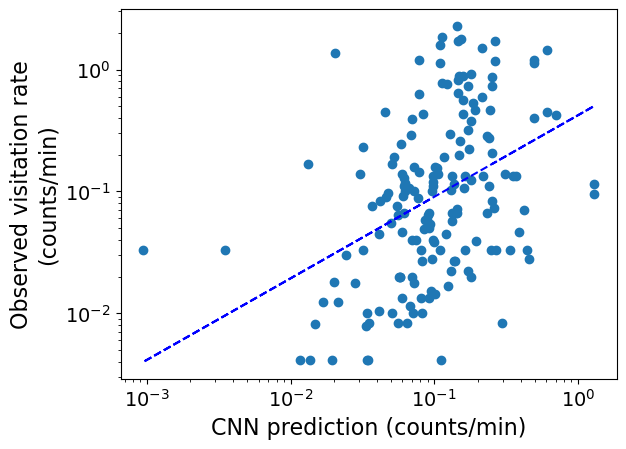

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Exponenciar los valores de los puntos
y_true_exp = np.exp(y_true_array)
y_pred_exp = np.exp(y_pred_array)


# Ajustar una línea de regresión con numpy en la escala exponencial
coef = np.polyfit(np.log10(y_pred_exp), np.log10(y_true_exp), 1)
poly1d_fn = np.poly1d(coef)

# Crear una gráfica de dispersión con la línea de regresión
plt.scatter(y_pred_exp, y_true_exp, label='Data')
plt.plot(y_pred_exp, 10**poly1d_fn(np.log10(y_pred_exp)), color='blue', linestyle='--')


# Configurar los ejes en escala logarítmica en base diez
plt.xscale('log')
plt.yscale('log')

# Añadir etiquetas a los ejes
plt.xlabel('CNN prediction (counts/min)', fontsize=16)
plt.ylabel('Observed visitation rate\n(counts/min)', fontsize=16)

# Ajustar el tamaño de los valores de los ejes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar la imagen
plt.savefig('../Figures/CNN_scatter_plot_log_scale.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()


In [11]:
# Calcular el coeficiente de correlación de Pearson
pearson_corr, _ = pearsonr(y_true_exp, y_pred_exp)
print(f"Pearson correlation coefficient: {pearson_corr}")

# Calcular el coeficiente rho de Spearman
spearman_corr, _ = spearmanr(y_true_exp, y_pred_exp)
print(f"Spearman rho: {spearman_corr}")

Pearson correlation coefficient: 0.16357909601285353
Spearman rho: 0.4399167953903466
